# Stroke Prediction AI

### Install library yang dibutuhkan

In [1]:
%pip install pandas scikit-learn matplotlib imblearn

Note: you may need to restart the kernel to use updated packages.


### 1. Siapkan data

In [2]:
import pandas as pd

df = pd.read_csv('../data/healthcare-dataset-stroke-data.csv')

df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### 2. Lakukan Preprocessing

In [3]:
# tampilkan semua kemungkinan nilai dari setiap kolom
for col in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    print(f'{col}: {df[col].unique()}')

gender: ['Male' 'Female' 'Other']
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type: ['Urban' 'Rural']
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


Terdapat kolom yang berisi data kategorikal, yaitu kolom 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'. Kita akan melakukan encoding terhadap data kategorikal tersebut.

In [4]:
from sklearn.preprocessing import LabelEncoder

# Melakukan label encoding, mengubah nilai kategori menjadi nilai numerik
label_encoders = {}
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    
# Menampilkan hasil label encoding
for col in categorical_columns:
    print(f'{col}: {df[col].unique()}')

gender: [1 0 2]
ever_married: [1 0]
work_type: [2 3 0 4 1]
Residence_type: [1 0]
smoking_status: [1 2 3 0]


In [5]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

kolom bmi memiliki missing value, kita akan mengisi missing value tersebut dengan metode K-Nearest Neighbors.

In [6]:
from sklearn.impute import KNNImputer

# Pisahkan data yang memiliki nilai BMI dan yang tidak
df_with_bmi = df[df["bmi"].notnull()]
df_without_bmi = df[df["bmi"].isnull()]

# Menggunakan KNNImputer untuk memprediksi nilai BMI yang hilang
imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(df)

# Mengubah hasil imputasi menjadi dataframe
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

df_imputed.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Hapus kolom 'id' karena tidak relevan dengan model.

In [7]:
# Hapus kolom id
df_imputed.drop(columns=['id'], inplace=True)

# Menampilkan data setelah id dihapus
df_imputed.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,67.0,0.0,1.0,1.0,2.0,1.0,228.69,36.60,1.0,1.0
1,0.0,61.0,0.0,0.0,1.0,3.0,0.0,202.21,28.08,2.0,1.0
2,1.0,80.0,0.0,1.0,1.0,2.0,0.0,105.92,32.50,2.0,1.0
3,0.0,49.0,0.0,0.0,1.0,2.0,1.0,171.23,34.40,3.0,1.0
4,0.0,79.0,1.0,0.0,1.0,3.0,0.0,174.12,24.00,2.0,1.0


Pisahkan kolom Features dan Target.

In [8]:
X = df_imputed.drop(columns=['stroke'])
y = df_imputed['stroke']

### 3. Split data

kita akan membagi data menjadi data training dan data testing dengan perbandingan 80:20.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

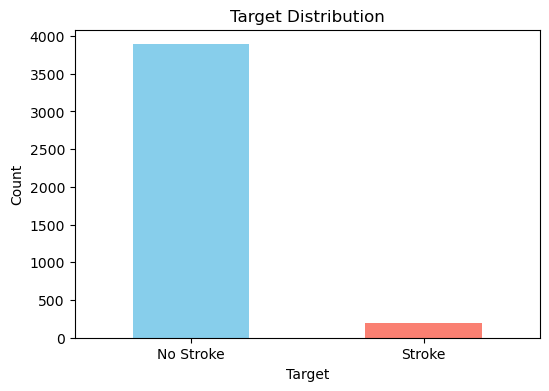

In [10]:
import matplotlib.pyplot as plt

# Menampilkan distribusi target
plt.figure(figsize=(6, 4))
pd.Series(y_train).value_counts().plot(kind='bar', color=['skyblue', 'salmon'], title='Target Distribution')
plt.xticks([0, 1], ['No Stroke', 'Stroke'], rotation=0)
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

Terlihat pada grafik di atas, distribusi nilai target tidak seimbang. Oleh karena itu, kita akan menggunakan SMOTE untuk menyeimbangkan data.

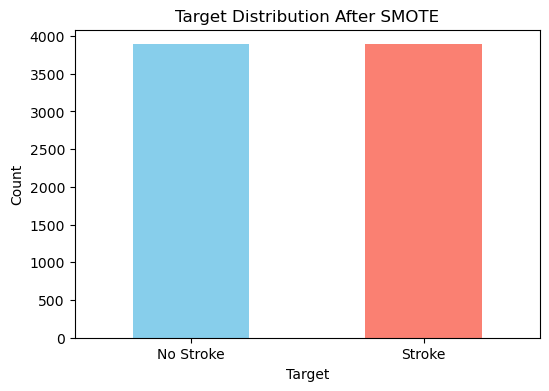

In [11]:
from imblearn.over_sampling import SMOTE

# Melakukan resampling dengan SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Menampilkan distribusi target setelah resampling
plt.figure(figsize=(6, 4))
pd.Series(y_train_resampled).value_counts().plot(kind='bar', color=['skyblue', 'salmon'], title='Target Distribution After SMOTE')
plt.xticks([0, 1], ['No Stroke', 'Stroke'], rotation=0)
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

### 4. Membuat model

Kami akan mencoba model Gradient Boosting Classifier, SVM, dan Logistic Regression.

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Membuat pipeline untuk masing-masing model
gbc_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('gbc', GradientBoostingClassifier(random_state=42))
])
svm_pipeline = Pipeline(
    steps=[("scaler", StandardScaler()), ("svm", SVC(random_state=42))]
)
lr_pipeline = Pipeline(
    steps=[("scaler", StandardScaler()), ("lr", LogisticRegression(random_state=42))]
)

# Melatih model
gbc_pipeline.fit(X_train_resampled, y_train_resampled)
svm_pipeline.fit(X_train_resampled, y_train_resampled)
lr_pipeline.fit(X_train_resampled, y_train_resampled)

# Melakukan Prediksi
gbc_train_preds = gbc_pipeline.predict(X_test)
svm_train_preds = svm_pipeline.predict(X_test)
lr_train_preds = lr_pipeline.predict(X_test)

# Menampilkan evaluasi model
print("Gradient Boosting Classifier:")
print(classification_report(y_test, gbc_train_preds))
print("Accuracy:", accuracy_score(y_test, gbc_train_preds))
print("\nSupport Vector Machine:")
print(classification_report(y_test, svm_train_preds))
print("Accuracy:", accuracy_score(y_test, svm_train_preds))
print("\nLogistic Regression:")
print(classification_report(y_test, lr_train_preds))
print("Accuracy:", accuracy_score(y_test, lr_train_preds))

Gradient Boosting Classifier:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98       972
         1.0       0.80      0.08      0.15        50

    accuracy                           0.95      1022
   macro avg       0.88      0.54      0.56      1022
weighted avg       0.95      0.95      0.94      1022

Accuracy: 0.9540117416829745

Support Vector Machine:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94       972
         1.0       0.18      0.30      0.22        50

    accuracy                           0.90      1022
   macro avg       0.57      0.61      0.58      1022
weighted avg       0.92      0.90      0.91      1022

Accuracy: 0.8972602739726028

Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.99      0.75      0.85       972
         1.0       0.14      0.80      0.24        50

    accuracy                           0.75    

Kami memilih Logistic Regression karena memiliki **recall yang tinggi** untuk kelas minoritas (kelas 1), yaitu **sebesar 80%**. Hal ini jauh lebih baik dibandingkan model lain, seperti **Gradient Boosting dengan recall hanya 8% dan SVM dengan 30%**. Kami **tidak mengutamakan accuracy karena dataset yang digunakan memiliki ketidakseimbangan kelas yang signifikan**, di mana kelas mayoritas mendominasi. Dalam situasi ini, **accuracy cenderung menyesatkan karena lebih mencerminkan keberhasilan prediksi pada kelas mayoritas**. Dengan fokus pada recall, kami memastikan lebih banyak kasus positif terdeteksi, yang menjadi prioritas utama dalam analisis ini.

#### output dari classifier

In [13]:
print("\nLogistic Regression:")
print(classification_report(y_test, lr_train_preds))
print("Accuracy:", accuracy_score(y_test, lr_train_preds))


Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.99      0.75      0.85       972
         1.0       0.14      0.80      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.78      0.55      1022
weighted avg       0.95      0.75      0.82      1022

Accuracy: 0.7524461839530333


In [14]:
import joblib

# Simpan model
joblib.dump(lr_pipeline, '../bin/model.pkl')

['../bin/model.pkl']